In [1]:
import os
import shutil
import random

base_data_dir = "/kaggle/input/hpv-dataset/clustered_data"

def train_test_val_splitter(base_data_dir, train_percentage=0, test_percentage=0, val_percentage=0):
    folders = os.listdir(base_data_dir)

    for folder in folders:
        os.makedirs(f"dataset_ttv/train/{folder}", exist_ok=True)
        os.makedirs(f"dataset_ttv/test/{folder}", exist_ok=True)
        os.makedirs(f"dataset_ttv/val/{folder}", exist_ok=True)

        source_folder = os.path.join(base_data_dir, folder)
        all_files = os.listdir(source_folder)
        total_images = len(all_files)

        print("TOTAL IMAGES:", total_images, f"in folder: {folder}")

        train_count = round((train_percentage / 100) * total_images)
        test_count = round((test_percentage / 100) * total_images)
        val_count = total_images - train_count - test_count  

        random.shuffle(all_files)
        train_files = all_files[:train_count]
        test_files = all_files[train_count:train_count + test_count]
        val_files = all_files[train_count + test_count:]

        for file_list, split in zip([train_files, test_files, val_files], ['train', 'test', 'val']):
            for file_name in file_list:
                src_path = os.path.join(source_folder, file_name)
                dest_path = os.path.join(f"dataset_ttv/{split}/{folder}", file_name)
                shutil.copy2(src_path, dest_path)  # ✅ Changed from move to copy2

        print(f"Copied {len(train_files)} train, {len(test_files)} test, {len(val_files)} val files for folder: {folder}")


In [2]:
!rm -rf dataset_ttv

In [3]:
train_test_val_splitter(base_data_dir, train_percentage=70, test_percentage=15, val_percentage=15)

TOTAL IMAGES: 2196 in folder: cluster_1
Copied 1537 train, 329 test, 330 val files for folder: cluster_1
TOTAL IMAGES: 3572 in folder: cluster_0
Copied 2500 train, 536 test, 536 val files for folder: cluster_0


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train=ImageDataGenerator(rescale=1./255)
validation=ImageDataGenerator(rescale=1./255)
test=ImageDataGenerator(rescale=1./255)
data_path = "/kaggle/working/dataset_ttv"

train_dataset=train.flow_from_directory(f"{data_path}/train",
                                        target_size=(256,256),
                                        batch_size=6,
                                        class_mode="binary",
                                        shuffle=True)

validation_dataset=train.flow_from_directory(f"{data_path}/val",
                                        target_size=(256,256),
                                        class_mode="binary",
                                        # batch_size=12,
                                        shuffle=False)

test_dataset=test.flow_from_directory(f"{data_path}/test",
                                      target_size=(256,256),
                                      class_mode="binary",
                                      shuffle=False)
train_dataset.class_indices


2025-05-14 11:57:29.099766: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747223849.622930      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747223849.759876      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 4037 images belonging to 2 classes.
Found 866 images belonging to 2 classes.
Found 865 images belonging to 2 classes.


{'cluster_0': 0, 'cluster_1': 1}

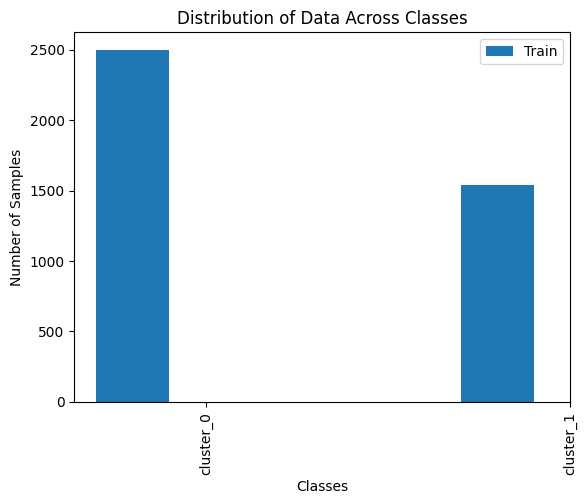

In [5]:
import matplotlib.pyplot as plt

class_indices = train_dataset.class_indices
class_labels = list(class_indices.keys())

train_class_counts = train_dataset.classes
train_class_counts = [sum(train_class_counts == i) for i in range(len(class_labels))]
bar_width = 0.2
index = range(len(class_labels))

plt.bar(index, train_class_counts, width=bar_width, label='Train')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Distribution of Data Across Classes')
plt.xticks([i + bar_width for i in index], class_labels, rotation=90, ha='center')
plt.legend()
plt.show()

In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

train_class_weights = compute_class_weight(class_weight="balanced",
                                           classes=np.unique(train_dataset.classes),
                                           y=train_dataset.classes)


train_class_weight_dict = dict(enumerate(train_class_weights))

train_class_weight_dict

num_of_classes=len(train_dataset.class_indices)
num_of_classes

2

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB0, ResNet50

# base_model = EfficientNetB0(weights="imagenet", include_top=False, pooling='avg', input_shape=(256,256,3))
base_model = ResNet50(weights="imagenet", include_top=False, pooling='avg', input_shape=(256,256,3))

base_model.trainable = False

model= Sequential()

model.add(base_model)

# model.add(Flatten())
# model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
# model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

In [49]:
from tensorflow.keras.optimizers import RMSprop, Nadam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

model.compile(optimizer=RMSprop(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=3,
                              min_lr=1e-7)

early_stopping_accuracy = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    min_delta=1e-4,
    mode="max",
    restore_best_weights=False
)

early_stopping_loss = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-4,
    mode="min",
    restore_best_weights=False
)

best_checkpoint = ModelCheckpoint('best_model.h5',
                                  monitor='val_loss',
                                  save_best_only=True,
                                  save_weights_only=False,
                                  mode='min',
                                  verbose=1)

last_checkpoint = ModelCheckpoint('last_model.h5',
                                  save_best_only=False,
                                  save_weights_only=False,
                                  verbose=1)

In [51]:
import os
import pandas as pd

total_epochs = 30  
epochs_per_chunk = 3
initial_epoch = 0

excel_file_path = "training_history.xlsx"

if os.path.exists(excel_file_path):
    history_df = pd.read_excel(excel_file_path)
else:
    history_df = pd.DataFrame()

while initial_epoch < total_epochs:
    print(f"\nTraining from epoch {initial_epoch+1} to {initial_epoch + epochs_per_chunk}...\n")

    history = model.fit(
        train_dataset,
        initial_epoch=initial_epoch,
        epochs=initial_epoch + epochs_per_chunk,
        validation_data=validation_dataset,
        shuffle=True,
        class_weight=train_class_weight_dict,
        callbacks=[early_stopping_accuracy, early_stopping_loss, reduce_lr, best_checkpoint, last_checkpoint],
        # batch_size=6,
        steps_per_epoch=len(train_dataset),
        verbose=True
    )

    chunk_history_df = pd.DataFrame(history.history)
    chunk_history_df["epoch"] = range(initial_epoch + 1, initial_epoch + len(chunk_history_df) + 1)

    history_df = pd.concat([history_df, chunk_history_df], ignore_index=True)

    history_df.to_excel(excel_file_path, index=False)
    print(f"Saved training history to {excel_file_path}")

    initial_epoch += epochs_per_chunk

    response = input(f"Completed {initial_epoch} epochs. Do you want to continue training? (yes/no): ").lower()
    if response != 'yes':
        print("Training stopped by user.")
        break



Training from epoch 1 to 3...

Epoch 1/3
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.6104 - loss: 0.6896
Epoch 1: val_loss improved from inf to 0.54424, saving model to best_model.h5

Epoch 1: saving model to last_model.h5
673/673 ━━━━━━━━━━━━━━━━━━━━ 153s 208ms/step - accuracy: 0.6105 - loss: 0.6896 - val_accuracy: 0.8233 - val_loss: 0.5442 - learning_rate: 0.0010
Epoch 2/3
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7591 - loss: 0.5493
Epoch 3: val_loss did not improve from 0.48191

Epoch 3: saving model to last_model.h5
673/673 ━━━━━━━━━━━━━━━━━━━━ 130s 193ms/step - accuracy: 0.7591 - loss: 0.5493 - val_accuracy: 0.8048 - val_loss: 0.5169 - learning_rate: 0.0010
Saved training history to training_history.xlsx


Completed 3 epochs. Do you want to continue training? (yes/no):  yes



Training from epoch 4 to 6...

Epoch 4/6
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7645 - loss: 0.5470
Epoch 4: val_loss improved from 0.48191 to 0.48179, saving model to best_model.h5

Epoch 4: saving model to last_model.h5
673/673 ━━━━━━━━━━━━━━━━━━━━ 132s 196ms/step - accuracy: 0.7645 - loss: 0.5470 - val_accuracy: 0.8776 - val_loss: 0.4818 - learning_rate: 0.0010
Epoch 5/6
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7632 - loss: 0.5418
Epoch 5: val_loss improved from 0.48179 to 0.47680, saving model to best_model.h5

Epoch 5: saving model to last_model.h5
673/673 ━━━━━━━━━━━━━━━━━━━━ 130s 193ms/step - accuracy: 0.7632 - loss: 0.5418 - val_accuracy: 0.8834 - val_loss: 0.4768 - learning_rate: 0.0010
Epoch 6/6
673/673 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7823 - loss: 0.5283
Epoch 6: val_loss did not improve from 0.47680

Epoch 6: saving model to last_model.h5
673/673 ━━━━━━━━━━━━━━━━━━━━ 130s 193ms/step - accuracy: 0.7823 - loss: 0.5284 - val_a

Completed 6 epochs. Do you want to continue training? (yes/no):  no


KeyboardInterrupt: Interrupted by user

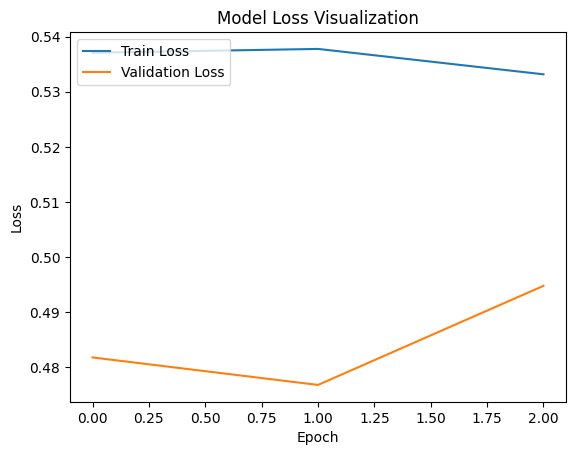

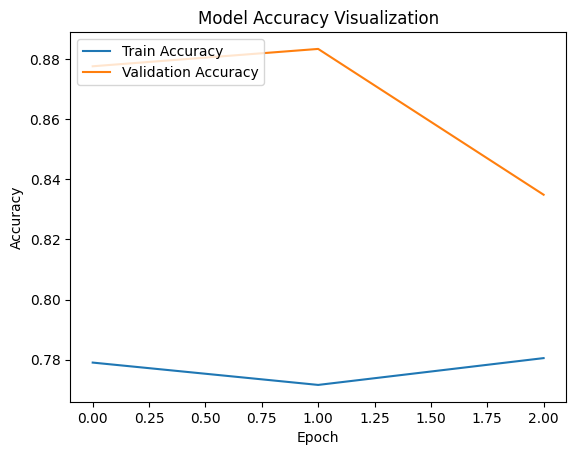

In [52]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Visualization')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper left')
plt.show()


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Visualization')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

In [66]:
from tensorflow.keras.models import load_model


# loaded_model = load_model("/kaggle/working/best_model.h5")
# loaded_model = load_model("/kaggle/working/last_model.h5")
loaded_model = load_model("/kaggle/working/model_training/last_model.h5")
test_results = loaded_model.evaluate(test_dataset)
print(f"Test Loss: {test_results[0]}")
print(f"Test Accuracy: {test_results[1]*100} %")


28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 820ms/step - accuracy: 0.7536 - loss: 0.5568
Test Loss: 0.4944168031215668
Test Accuracy: 84.16184782981873 %


In [69]:
from sklearn.metrics import classification_report

y_true = test_dataset.classes

y_pred_probs = loaded_model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype(int)

class_labels = list(test_dataset.class_indices.keys())

report = classification_report(y_true, y_pred, target_names=class_labels)

print(report)

28/28 ━━━━━━━━━━━━━━━━━━━━ 23s 805ms/step
              precision    recall  f1-score   support

   cluster_0       1.00      0.74      0.85       536
   cluster_1       0.71      1.00      0.83       329

    accuracy                           0.84       865
   macro avg       0.85      0.87      0.84       865
weighted avg       0.89      0.84      0.84       865



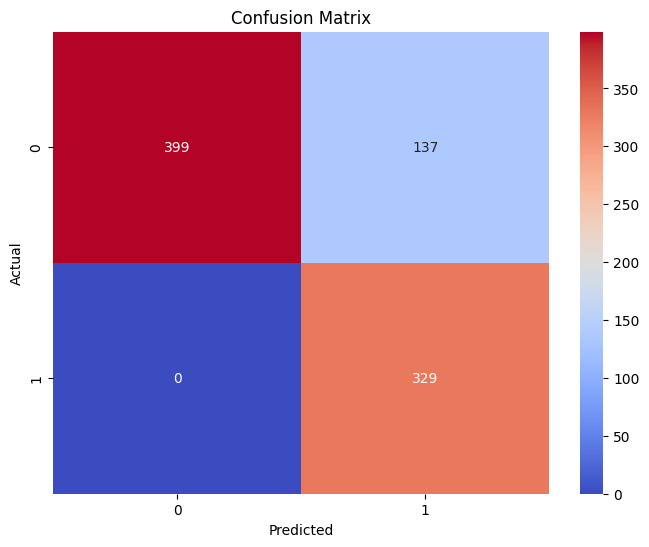

In [70]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

conf_matrix = confusion_matrix(y_true, y_pred)

classes = np.unique(y_true).tolist()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm', fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [56]:
!rm -rf model_training

In [57]:
import shutil
import os

target_dir = "model_training"
os.makedirs(target_dir, exist_ok=True)

files_to_move = ["training_history.xlsx", "last_model.h5", "best_model.h5"]

for file in files_to_move:
    if os.path.exists(file):
        shutil.move(file, os.path.join(target_dir, file))
        print(f"Moved {file} to {target_dir}/")
    else:
        print(f"Warning: {file} not found and could not be moved.")


Moved training_history.xlsx to model_training/
Moved last_model.h5 to model_training/
Moved best_model.h5 to model_training/


'/kaggle/working/medical_model.zip'